# Learn++

In [1]:
from sklearn.tree import DecisionTreeClassifier
from skmultiflow.utils import check_random_state
import copy
import numpy as np
import random
import pandas as pd
import math

# 1. Implementation of Learn++

In [2]:
class LearnPP:

    def __init__(self, base_estimator=DecisionTreeClassifier(), n_estimators=30, n_ensembles=10, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.ensembles = []
        self.ensemble_weights = []
        self.classes = None
        self.n_ensembles = n_ensembles
        self.random = check_random_state(random_state)

    def partial_fit(self, X, y=None, classes=None):
        if self.classes is None:
            if classes is None:
                raise ValueError("Should pass the classes in the first partial_fit call")
            else:
                self.classes = classes

        if classes is not None and self.classes is not None:
            if set(classes) == set(self.classes):
                pass
            else:
                raise ValueError("The values of classes are different")

        ensemble = [copy.deepcopy(self.base_estimator) for _ in range(self.n_estimators)]
        normalized_errors = [1.0 for _ in range(self.n_estimators)]

        m = len(X)
        X = np.array(X)
        y = np.array(y)

        items_index = np.linspace(0, m - 1, m)
        t = 0
        while t < self.n_estimators:
            patience = 0

            # Set distribution Dt
            Dt = np.ones((m,)) / m

            total_error = 1.0
            while total_error >= 0.5:

                # create training and testing subsets according to Dt
                train_size = int(m / 2)
                test_size = int(m / 2)
                train_items_index = self.get_item(items_index, Dt, train_size)
                test_items_index = self.get_item(items_index, Dt, test_size)

                X_train = X[train_items_index]
                y_train = y[train_items_index]
                X_test = X[test_items_index]
                y_test = y[test_items_index]

                # Train a weak learner
                ensemble[t] = copy.deepcopy(self.base_estimator)
                ensemble[t].fit(X_train, y_train)

                # predict on the data
                y_predict = ensemble[t].predict(X_test)

                total_error = self.compute_error(Dt[test_items_index], y_test, y_predict)

                # print("Error 1" , total_error)
                if total_error < 0.5:
                    # print("Error < 0.5", total_error)
                    norm_error = total_error / (1 - total_error)
                    normalized_errors[t] = norm_error

                    # predict using all hypothesis in the ensemble with majority votes
                    y_predict_composite = self.majority_vote(X, t + 1, ensemble, normalized_errors)

                    total_error = self.compute_error(Dt, y, y_predict_composite)
                    if total_error < 0.5:
                        normalize_composite_error = total_error / (1 - total_error)
                        if t < self.n_estimators - 1:
                            Dt[y_predict_composite == y] = Dt[y_predict_composite == y] * normalize_composite_error

                # print("Error 2", total_error)

                if total_error > 0.5:
                    patience += 1
                if patience > 20:
                    raise RuntimeError("Your base estimator is too weak")
            t += 1

        self.ensembles.append(ensemble)
        self.ensemble_weights.append(normalized_errors)

        if len(self.ensembles) > self.n_ensembles:
            self.ensembles.pop(0)
            self.ensemble_weights.pop(0)

        return self

    def compute_error(self, Dt, y_true, y_predict):
        total_error = np.sum(Dt[y_predict != y_true]) / np.sum(Dt)
        return total_error

    def vote_proba(self, X, t, ensemble, normalized_errors):
        res = []
        for m in range(len(X)):
            votes = np.zeros(len(self.classes))
            for i in range(t):
                h = ensemble[i]

                y_predicts = h.predict(X[m].reshape(1, -1))
                norm_error = normalized_errors[i]
                votes[int(y_predicts[0])] += np.log(1 / norm_error)

            res.append(votes)
        return res

    def majority_vote(self, X, t, ensemble, normalized_errors):
        res = self.vote_proba(X, t, ensemble, normalized_errors)
        return np.argmax(res, axis=1)

    def predict(self, X):
        votes = np.zeros((len(X), len(self.classes)))
        for i in range(len(self.ensembles)):
            ensemble = self.ensembles[i]
            ensemble_weight = self.ensemble_weights[i]
            votes += np.array(self.vote_proba(X, self.n_estimators, ensemble, ensemble_weight))
        return np.argmax(votes, axis=1)

    def get_item(self, items, items_weights, number_of_items):
        return self.random.choice(items, number_of_items, p=items_weights).astype(np.int32)


# 2. Evaluation

The following piece of code evaluates the three classifiers and gives the online visualization. It computes the current and global values for `accuracy` and `kappa`. Current value of selected evaluation measure represents the performance of the model on the current window and global value represents the performance of the model on whole datastream. `EvaluatePrequential` also gives the summary of evaluation showing the `Evaluation Time`.

<IPython.core.display.Javascript object>


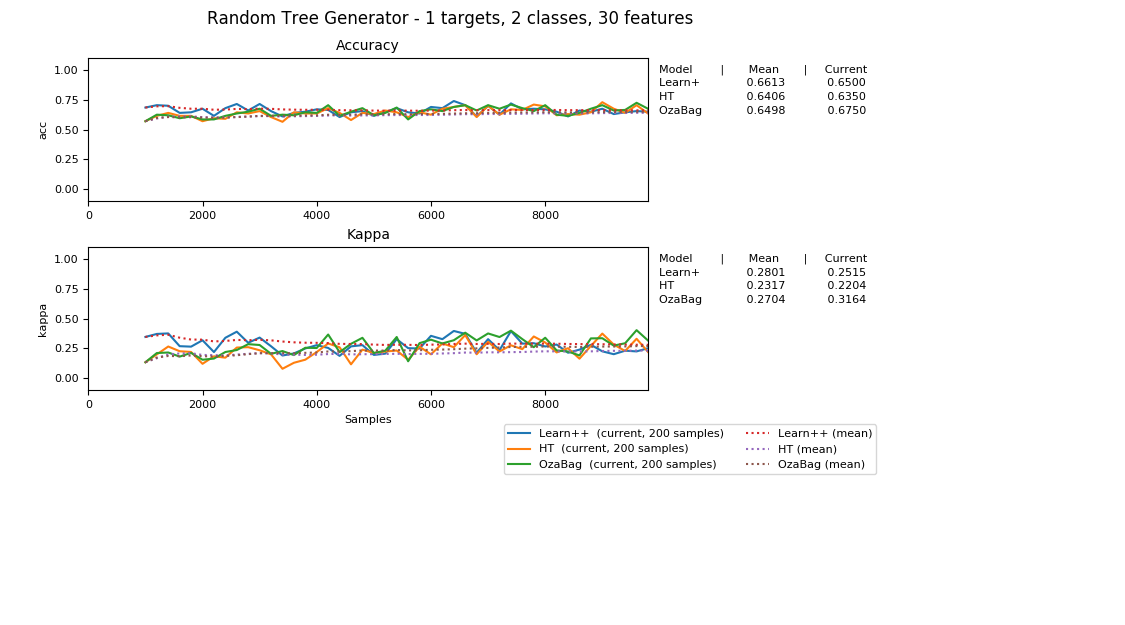

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1000 sample(s).
Evaluating...
 #################### [98%] [805.76s]
Processed samples: 10000
Mean performance:
Learn++ - Accuracy     : 0.6613
Learn++ - Kappa        : 0.2801
HT - Accuracy     : 0.6406
HT - Kappa        : 0.2317
OzaBag - Accuracy     : 0.6498
OzaBag - Kappa        : 0.2704


In [3]:
from skmultiflow.trees import HoeffdingTree
from skmultiflow.data import RandomTreeGenerator
from skmultiflow.meta import OzaBagging
from skmultiflow.evaluation.evaluate_prequential import EvaluatePrequential
from sklearn.neural_network import MLPClassifier
import matplotlib as plt

%matplotlib notebook

# 1. Create a stream

stream = RandomTreeGenerator(tree_random_state=0, sample_random_state=0)
# 2. Prepare for use
stream.prepare_for_use()
# 2. Instantiate the HoeffdingTree classifier
h = [
    LearnPP(base_estimator=MLPClassifier(hidden_layer_sizes=(128,), tol=1e-3, max_iter=500)
            , n_estimators=30, random_state=1),
    HoeffdingTree(),
    OzaBagging(base_estimator=HoeffdingTree(), n_estimators=5, random_state=5)
     ]

# 3. Setup the evaluator

evaluator = EvaluatePrequential(pretrain_size=1000, show_plot=True, max_samples=10000,
                                metrics=['accuracy', 'kappa'], batch_size=200, output_file="result.csv")
# 4. Run
evaluator.evaluate(stream=stream, model=h, model_names=['Learn++', "HT", "OzaBag"])

# Generating plot

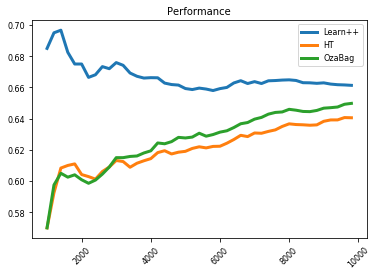

In [8]:
import pandas as pd
from matplotlib.pyplot import *

dataset = "poker"

df = pd.read_csv('result.csv', comment='#')
ax = df.plot(x="id", y=["mean_acc_[Learn++]","mean_acc_[HT]","mean_acc_[OzaBag]"], rot=45, linewidth=3, title="Performance")
ax.set_xlabel("")
ax.set_title("Performance")
ax.legend(['Learn++', "HT", "OzaBag"], loc='best')
savefig("result.pdf")
show()